In [1]:
import matplotlib.pyplot as plt
%matplotlib widget
from pathlib import Path

from noise import *
from utils import init_config, datetime_from_filename

In [2]:
counters = ['bardeen','bell','curie','feynman','newton','noether','rossi','rubin','rutherford','wu','einstein','yukawa','dirac','meitner']
niche_data_dir = Path('/home/isaac/niche_data/')

In [3]:
varcloseddict = {}
varopendict = {}
timedict = {}

for counter in counters:
    varclosedlist = []
    varopenlist = []
    timelist = []
    for datepath in niche_data_dir.iterdir():
        datadir = datepath / counter
        if datadir.exists():
            datafiles = [f for f in datadir.iterdir() if f.name.endswith('.bin') and f.name[-5].isnumeric()]
            cfgs = [init_config(f.name[:-4]) for f in datafiles]
            noise_open = []
            noise_closed = []
            for cfg in cfgs:
                noise_open.extend([f for f in cfg.noise_open_files if f.parent.name == counter])
                noise_closed.extend([f for f in cfg.noise_closed_files if f.parent.name == counter])
            try:
                varclosedlist.extend([noise_fft(read_noise_file(f)).mean() for f in noise_closed])
                varopenlist.extend([noise_fft(read_noise_file(f)).mean() for f in noise_open])
                timelist.extend([datetime_from_filename(f) for f in noise_closed])
            except:
                continue
    varcloseddict[counter] = np.array(varclosedlist)
    varopendict[counter] = np.array(varopenlist)
    timedict[counter] = np.array(timelist)
    
    

ValueError: operands could not be broadcast together with shapes (1156,) (1161,) 

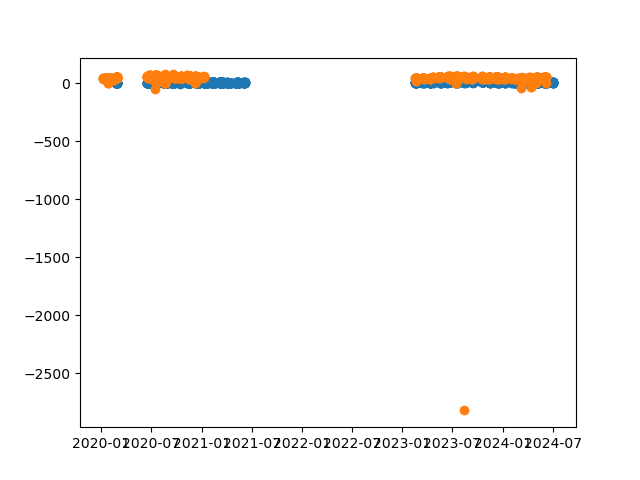

In [4]:
plt.figure()
for counter in counters:
    plt.scatter(timedict[counter],np.array(varopendict[counter])-np.array(varcloseddict[counter]))